In [1]:
# prova a fare con keras e tf
import numpy as np
import pandas as pd
import seaborn as sns 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

sns.set(font_scale=1.2)
sns.set_style('whitegrid')
#%matplotlib inline

In [2]:
model_testing = 'y'
data_checks = 'n'
preproc_log = 'n' # se lo accendo non impara più nulla, con lo Z invece funziona

# hyperparameters: learning_rate, batch_size, 
# choice of the optimizer (algorithm)

**Osservazioni**
- Ci sono volte in cui *sembra che nn impari*, nel senso che nn si smuove dal 75% sul training set mentre sul validation rimane inchiodato al 50%, ie spara a caso (forse è legato a quando ne uso il log nel preprocessing?) 
- ad h nn siamo mai riusciti a superare il 75% (il che è un po' triste)
- arriva in fretta il 75%, nel senso che ci mette proprio poche epochs (con il solito batch di 100)

- 1 possibilità è che io lo stia facendo girare con troppi parametri, pké in fondo le features sono davvero pochissime! e lui stia subito imparando il dataset

**domande**
- ha senso metterli insieme? cosa si sta cercando, le info del W arrivano da 1 ricostruizione (ie il MET), c'è anche di mezzo un fit con tnt di chisq…
- log per contrastare gli outliers (così però nn impara…)
- qstione di sigmoid e relu

## TODOs
- [x] bisogna uniformare le features e levare gli outliers + palesi (qli dal chisq nel Wmunu)
- [x] prima li visualizziamo separatamente e droppiamo le colonne che nn ci interessano (dopo aver visto che sono scorrelate con la heatmap)
- [x] mischiamo tutto e controlliamo la popolosità (anche se mi aspetto che ci siano casini a riguardo, ma chissene)
domandone, ci interessa solo se le correlazioni sono lineari? o perlomeno dobbiamo stare attenti solo a quei casi?
- [x] controllare la feature engineering
- [x] costruire modelli e giocare con i parametri
- [ ] cosa cambiare? ottimizzatore e learning rate (dopo aver ristudiato cosa siano), aggiungere strati e cambiare numero di neuroni

**Riflessioni**
Se la dipendenza nn fosse banalmente lineare ma metti quadratica (ie cmq 1 relazione semplice da scovare) nn sarebbe cmq ridondante fornire entrambe le feature per l'allenamento?
forse è per questo che nn facciamo solo la heatmap ma anche il pairplot… -> per fare 1 cosa veloce facciamo solo la heatmap, per andare a cercare cose + fini (per qnto si faccia tutto ad occhio :) daje di pairplot -> in qst'ottica ha senso fare i pairplot separatamente (nel sense che nn ci interessa necessariamente vederli insieme) così nn ci mette 5 minuti ad eseguire per i dati merged

# Features W -> e + nu
Run number of the event, Event number, pt eta phi sono la cinematica dl'e, Q ne è la carica, type è dove hanno trovato l'e (se barrel o endcap del rivelatore), i del e il sigmaEtaEta si riferiscono tutti al cluster associato alla rilevazione dl'e, HoverE, tutti gli iso sono associati alla rivelazione dl'e, mentre i MET sono la cinematica dl nu

In [3]:
df_enu = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Wenu.csv')
df_enu['type'] = df_enu['type'].map({'EB': 0, 'EE': 1})

In [4]:
if data_checks=='y':
    df_enu.info()
    df_enu.head()

In [5]:
# to uniform datasets (could be wrong, I need more info on the datasets)
df_enu['iso'] = df_enu.apply(lambda x: x['isoTrack'] + x['isoEcal'] + x['isoHcal'],axis=1)
if data_checks=='y':
    df_enu.head(3)

In [6]:
# Adding class because of dataset merging 
df_e = df_enu[['pt','eta','phi','Q','iso','MET','phiMET']]
df_e.loc[:,'class'] = 'enu'

/var/folders/2z/_ll869ld6fxbv3kk_q_mqkg80000gn/T/ipykernel_11547/4077356703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e.loc[:,'class'] = 'enu'


In [7]:
if data_checks=='y':
    df_e.head(3)

## Data visualization, W -> e + nu

In [8]:
if data_checks=='y':
    scaler = preprocessing.MinMaxScaler()
    df_enu_scaled = scaler.fit_transform(df_enu)
    dfenu_array_to_dfenu = pd.DataFrame(df_enu_scaled, columns = df_enu.columns)
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfenu_array_to_dfenu, orient="h")

**Boxplot comment**: pt e MET sono gli unici che presentano *outliers* tra le feature che mi interessano

In [9]:
if data_checks=='y':
    fig, ax = plt.subplots(figsize=(20,20))
    # sns.set(font_scale=1.0)
    sns.heatmap(df_enu.corr() , annot= True, linewidths=3, ax=ax, cmap='mako')

**Heatmap comment**: Ricorda che questa è la correlazione (credo di Pearson), tutto buono non ci sono *linearità* tra le features

In [10]:
if data_checks=='y':
    # Unnecessary features already discarded (pairplot on df_e, not df_enu)
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    sns.pairplot(df_e, diag_kind='kde')

**Pairplot comment**: serve a vedere se le features sono *dipendenze*, potenzialmente nn lineari e quindi nn identificate con la heatmap. Nn ci sono dipendenze palesi, si può procedere

# Features W -> mu + nu
chisq (è ridotto!) è pké qste ricostruzioni arrivano da dei fit, chi quadri troppo alti sono evidentemente sospetti, dxy è il parametro d'impatto dl'evento, iso riguarda il parametro con cui si decreta di aver o meno misurato un mu

In [11]:
df_munu = pd.read_csv('~/Documents/tesi/thesis_notebooks/input_datasets/Wmunu.csv')

In [12]:
if data_checks=='y':
    df_munu.info()
    df_munu.sample(3)

Sbarazziamoci degli eventi inaffidabili, con chiSq troppo alto

In [13]:
chisq_th = 10 # threshold for acceptance of the data. It is a reduced chi squared!
not_trustworthy = df_munu[df_munu['chiSq'] > chisq_th]
len(not_trustworthy)

4802

In [14]:
df_munu.drop(not_trustworthy.index, inplace=True)
# print(len(df_munu[df_munu['chiSq']>100]))

In [15]:
# again in preparation for future merging
df_mu = df_munu[['pt','eta','phi','Q','iso','MET','phiMET']]
df_mu['class'] = df_mu['pt'].apply(lambda x: 'munu')

/var/folders/2z/_ll869ld6fxbv3kk_q_mqkg80000gn/T/ipykernel_11547/3753977111.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mu['class'] = df_mu['pt'].apply(lambda x: 'munu')


## Data visualization, W -> mu + nu

In [16]:
if data_checks=='y':
    df_munu_scaled = scaler.fit_transform(df_munu)
    dfmunu_array_to_dfmunu = pd.DataFrame(df_munu_scaled, columns = df_munu.columns)
    # aesthetics
    plt.figure(figsize=(20, 10)) 
    sns.set(font_scale=1.0)
    # boxplot
    sns.boxplot(data=dfmunu_array_to_dfmunu, orient="h")

Di nuovo pt e MET sono quelli con outliers (tra le features che mi interessano). Per il chi quadro devo scegliere una soglia, come se stessi facendo un test statistico (per quanto non possa essere ben fatto dal momente che nn ho la minima idea dei gradi di libertà della cosa)

In [17]:
if data_checks=='y':
    fig, ax = plt.subplots(figsize=(20,20))
    sns.set(font_scale=1.0)
    sns.heatmap(df_munu.corr() , annot= True, linewidths=3, ax=ax, cmap='mako')

Stesso discorso di prima, non si osservano correlazioni (lineari!) evidenti tra le feature

In [18]:
if data_checks=='y':
    # Already discarded unnecessary features (pairplot on df_mu, not df_munu)
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    sns.pairplot(df_mu, diag_kind='kde') # kde serve per avere le distribuzioni di probabilità (credo?)

# Merging data

In [19]:
del df_enu, df_munu

In [20]:
df = pd.concat([df_e,df_mu], ignore_index=True, sort=False)
df.sample(5)

,pt,eta,phi,Q,iso,MET,phiMET,class
166781,28.1440,0.7394,-0.4665,-1,16.0308,13.0931,-0.5797,munu
194598,44.9250,-1.5031,3.1050,1,2.0703,22.7043,0.0158,munu
172371,67.3831,-1.0740,2.0699,-1,42.7344,49.4055,2.5213,munu
36194,42.8721,0.7042,-0.8627,-1,5.6723,6.6410,2.7933,enu
180709,32.4672,0.1268,-2.9007,-1,3.0491,33.9650,0.3914,munu


In [21]:
del df_e, df_mu

## Data checks

In [22]:
if data_checks=='y':
    # Per verificare che il dataset sia bilanciato
    sns.countplot(data=df,x='class')

In [23]:
if data_checks=='y':
    plt.figure(figsize=(20, 10))
    sns.set(font_scale=2.0)
    fig_pairplot = sns.pairplot(df, hue="class", palette="deep")
    fig_pairplot.savefig('pairplot_merged.png')

**Merged Pairplot**: questo ha un'ulteriore utilità pké nonostante io abbia verificato che nn ci sono dipendenze evidenti separatamente tra le features, potenzialmente potrebbero esserci modi semplici di classificare sla base di poche feature (magari lo scatter tra 2 feature separa nettamente le 2 classi e quindi il problema di classificazione è immediatamente risolto). Effettivamente nn sembrano esserci maniere evidenti di risolvere il problema di classificazione a mano

## Dataframes to *train&test* the model

In [24]:
# Drop unnecessary features
df.drop(['iso','Q'], inplace=True, axis=1)

# map class to int
df['class'] = df['class'].map({'enu': 0, 'munu': 1})

In [25]:
# split labels from data
X = df.drop(['class'], axis=1)
y = df['class']

del df

In [26]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0) # this outputs pandas

In [27]:
X_train.head(5)

,pt,eta,phi,MET,phiMET
113147,33.4978,0.8993,-1.5531,18.5948,-1.6843
34029,28.4397,-0.9844,0.3626,11.0361,0.7729
184832,45.8711,-0.9208,1.2810,11.8654,-0.8906
83169,33.5682,-0.1798,0.4494,23.3605,1.8222
81435,41.1760,-2.1823,2.7081,47.2476,-0.4648


# Feature engineering

In [28]:
if preproc_log=='y':
    X_train["log(pt)"] = X_train['pt'].apply(np.log1p) # questa roba qua fa ln(1 + x) -> credo sia solo per prendere le distanze dla potenziale divergenza in 0
    X_train["log(MET)"] = X_train['MET'].apply(np.log1p) 
    
    X_train.drop(['pt','MET'], inplace=True, axis=1)
    X_train.sample(5)

**Standardizzazione** (mi porto a media 0 e varianza 1, è trasf lineare NN sto forzando i dati a distribuirsi normalmente!)

In [30]:
# Costruiamo il layer e informiamolo (ie ho solo 1 forma/STRUTTURA che adatto ai dati MA NN LO STO POPOLANDO!)
X_train_scaler = tf.keras.layers.Normalization(axis=-1) # axis=-1 gli dice come leggere il tensor ie in quale direz calcolare medie e varianze (qua banalmente se sle righe (axis=0) o sle colonne (axis=-1 o axis=1 fa li stès))
X_train_scaler.adapt(tf.convert_to_tensor(X_train)) # qua informiamo il layer sui dati, ie si calcola medie e varianze che userà poi

X_test_scaler = tf.keras.layers.Normalization(axis=-1)
X_test_scaler.adapt(tf.convert_to_tensor(X_test))

# Building and testing model

In [31]:
def my_model():
   model = tf.keras.Sequential([
    X_train_scaler,
    tf.keras.layers.Dense(28, activation='sigmoid'),
    tf.keras.layers.Dense(28, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation=tf.nn.softmax)       
   ])
   model.compile(
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                 loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                 metrics=['accuracy'])
   return model

model = my_model()

In [32]:
if model_testing=='y':
    history = model.fit(X_train, y_train, epochs=700, validation_data=(X_test, y_test), batch_size=100)

Epoch 1/700
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - accuracy: 0.6167 - loss: 0.6546 - val_accuracy: 0.6411 - val_loss: 0.6282
Epoch 2/700
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - accuracy: 0.6528 - loss: 0.6213 - val_accuracy: 0.6929 - val_loss: 0.5909
Epoch 3/700
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step - accuracy: 0.7029 - loss: 0.5776 - val_accuracy: 0.7255 - val_loss: 0.5568
Epoch 4/700
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.7242 - loss: 0.5525 - val_accuracy: 0.7283 - val_loss: 0.5429
Epoch 5/700
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.7311 - loss: 0.5378 - val_accuracy: 0.7351 - val_loss: 0.5311
Epoch 6/700
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - accuracy: 0.7374 - loss: 0.5273 - val_accuracy: 0.7376 - val_loss: 0.5240
Epoch 7/700
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.7402 - loss: 0.5189 - val_accuracy: 0.7368 - val_loss: 0.5213
Epoch 8/700
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1s 517us/step - accuracy: 

In [33]:
if model_testing=='y':
    model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5)              │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 28)             │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │           812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            58 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,127 (12.22 KB)

 Trainable params: 1,038 (4.05 KB)

 Non-trainable params: 11 (48.00 B)

 Optimizer params: 2,078 (8.12 KB)

## Performance check

Register
| model | the model learns? <br/> (y/n) | chiSq_th | preprocessing <br/> log (y/n)| scaler | model hidden <br/> layers (Dense) | batch size, epochs | max val_accuracy <br/> % |
|------|-----|-----|-------|------|------|----|-----|
| stupid | ? | 10 | n | keras.Norm | 128, 64 relu | (10, 100), 20 | 75? |
| learny | y | 10 | n | // | // | 50, 100 | 75 |
| overfitty | until epoch 100 <br/>(approx) | // | n | // | // | 100, 400 | 75 |
| 12864 | // | // | n | // | // | 100, 100 | 75 |
| 6464relu | y | // | n | n | 64,64 relu | 100, 100 | 75 |
| 6464sigm | y | // | n | n | 64,64 sigmoid | 100, 100 | 75 (1 po' meno del relu) |
| 2828sigm | y | // | n | n | 28,28 sigmoid | 100, 400 | 75 |
| 2828relu | y | // | n | n | 28,28 relu | 100, 700 | 75 |

al momento sembra che con la sigmoid il modello abbia meno problemi di overfitting ie il rapporto dle accuratezze è più vicino a 1 (lo vedi bene dle curve in foto)

it's convenient to use big batch sizes and many epochs in order to visualize the learning process in `history`. Moreover, don't worry about choosing `nepochs` in order to avoid overfitting because you record the entire learning process in the `history`

1220/1220 - 1s - 583us/step - accuracy: 0.7528 - loss: 0.4771


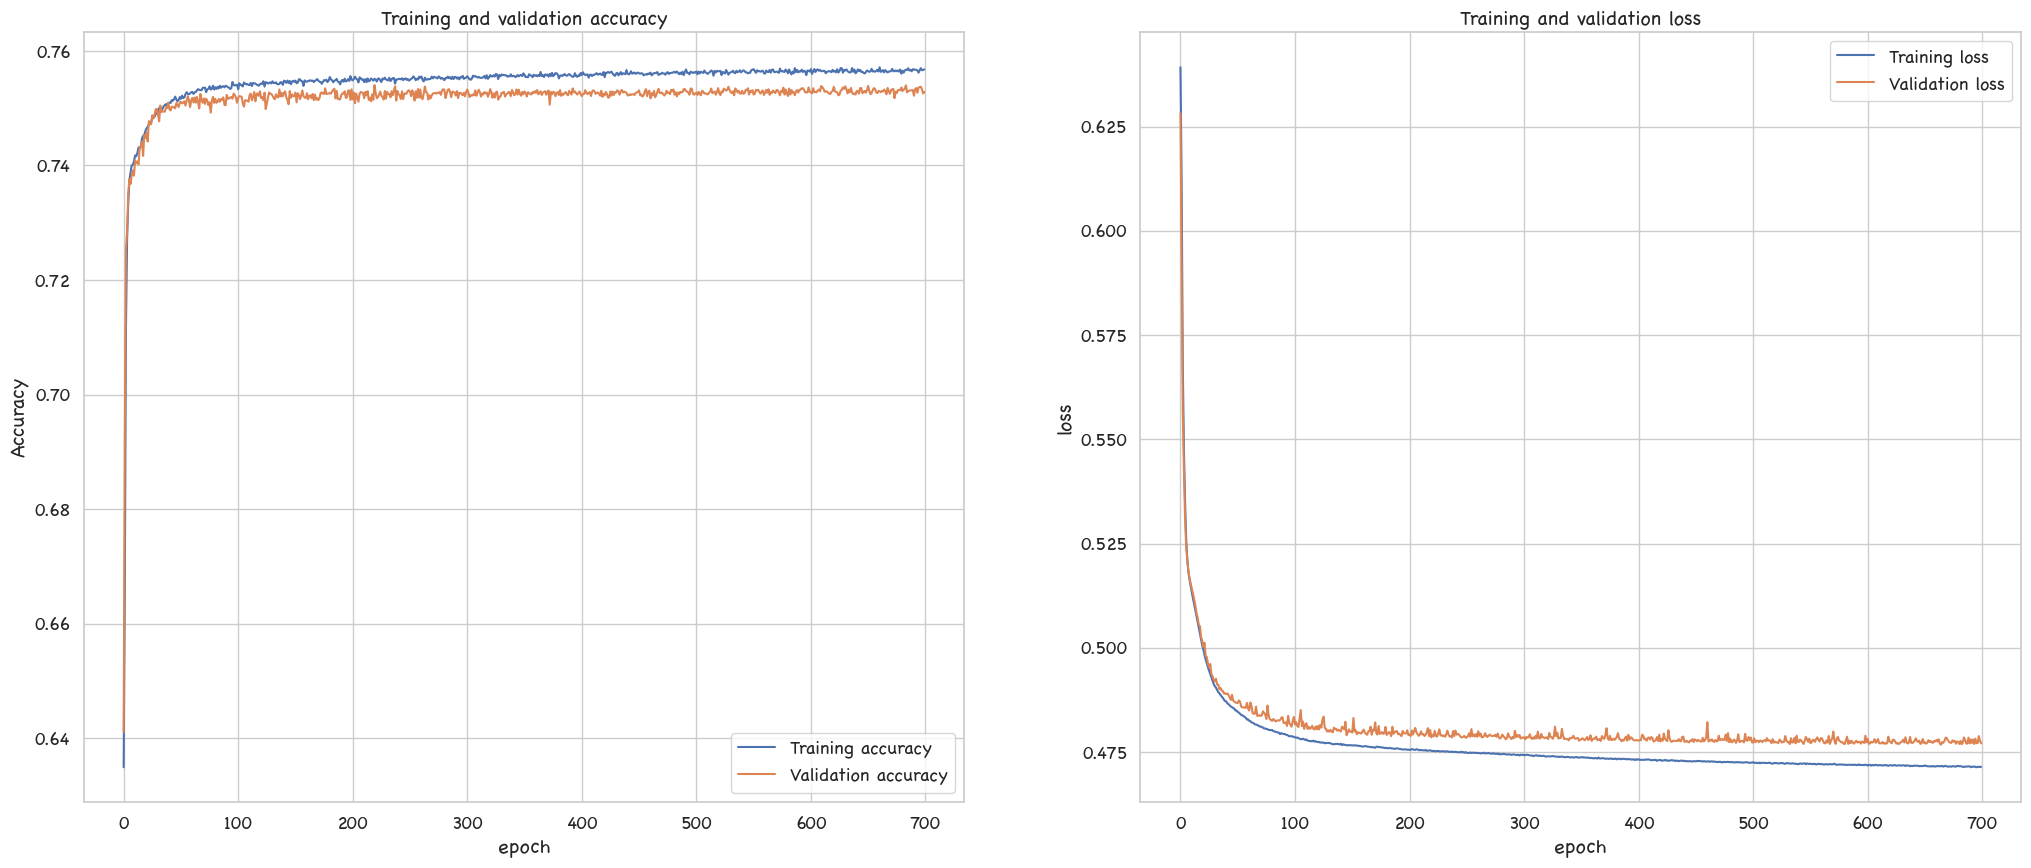

In [34]:
if model_testing=='y':
    # aesthetics
    font = {'family' : 'chalkboard',
            'weight' : 'bold',
            'size'   : 18}
    
    plt.rc('font', **font)
    
    fig = plt.figure(figsize=(25,10))
    ax1 = plt.subplot(121) # qsto sta per 1,2,1 ie nrows, ncol, index
    ax2 = plt.subplot(122)
    
    # what to plot on first figure (ax1)
    ax1.plot(history.history['accuracy'], label='Training accuracy') # qua specifico cosa plottare (le y, le x sono implicite in history)
    ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy') 
    
    ax1.set_title("Training and validation accuracy")
    ax1.set(xlabel='epoch', ylabel='Accuracy')
    ax1.legend(loc='lower right')
    
    # what to plot on first figure (ax1)
    ax2.plot(history.history['loss'], label='Training loss')
    ax2.plot(history.history['val_loss'], label='Validation loss')
    
    ax2.set_title("Training and validation loss")
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.legend(loc='upper right')
    
    #To check the network accuracy on test data
    test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

In [37]:
# fig.savefig('2828sigm700.png')